In [2]:
%matplotlib inline
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from mango import Tuner
import itertools

# Suppress all warnings
import warnings
warnings.simplefilter("ignore")

# Feature Engineering

In [3]:
# Predictive variable
pred_var = 'Additional_Doses_Vax_Pct'

# Import data with specific columns
df = pd.read_csv('df_post_eda.csv', usecols=['Date', pred_var])

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Group by 'Date' to ensure there is one unique value per date
df = df.groupby('Date').mean()

# Sorting the DataFrame by the index just to make sure it's in chronological order
df.sort_index(inplace=True)

# Now 'Date' is the index and I have the average of 'Additional_Doses_Vax_Pct' per date

# Confirming stationarity

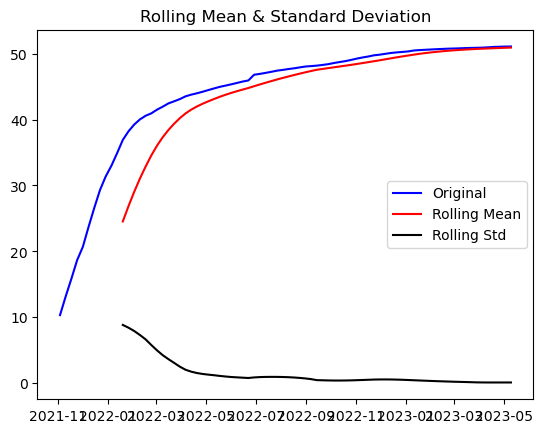

Results of Dickey-Fuller Test:
Test Statistic                 -4.009253
p-value                         0.001363
#Lags Used                      2.000000
Number of Observations Used    77.000000
Critical Value (1%)            -3.518281
Critical Value (5%)            -2.899878
Critical Value (10%)           -2.587223
dtype: float64


In [8]:
# Perform Augmented Dickey-Fuller test:
def test_stationarity(timeseries):

    # Determing rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()

    # Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Augmented Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    adf_test = adfuller(timeseries, autolag='AIC')
    adf_output = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in adf_test[4].items():
        adf_output['Critical Value (%s)' % key] = value
    print(adf_output)

# Testing
test_stationarity(df[pred_var])


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

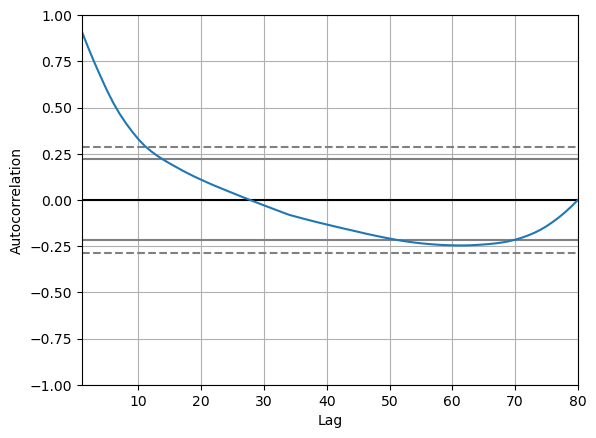

In [25]:

autocorrelation_plot(df[pred_var])

# Test and train

In [6]:
# Calculate the index for the 70-30 split
split_index = int(len(df) * 0.7)

# Split into train and test
train = df.iloc[:split_index][pred_var]
test = df.iloc[split_index:][pred_var]

# Check the size of each dataset
print(f"Training set size: {len(train_df)}, Test set size: {len(test_df)}")

Training set size: 56, Test set size: 24


# Model 1

In [40]:
# Initialize the ARIMA model
model = ARIMA(train, order=(2, 0, 1))

# Fit the ARIMA model
fitted_model = model.fit()

# Print out the summary of the fit model
print(fitted_model.summary())

                                  SARIMAX Results                                   
Dep. Variable:     Additional_Doses_Vax_Pct   No. Observations:                   50
Model:                       ARIMA(2, 0, 1)   Log Likelihood                 -14.709
Date:                      Mon, 13 Nov 2023   AIC                             39.419
Time:                              00:38:03   BIC                             48.979
Sample:                          11-03-2021   HQIC                            43.059
                               - 10-12-2022                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5711     48.469      0.032      0.974     -93.426      96.568
ar.L1          1.9889      0.007    267.634      0.000       1.974       2.004
ar.L

In [41]:
# Calculate the RMSE
rmse = sqrt(mean_squared_error(train, fitted_model.fittedvalues))
print('The Root Mean Squared Error of the forecasts is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of the forecasts is 1.33


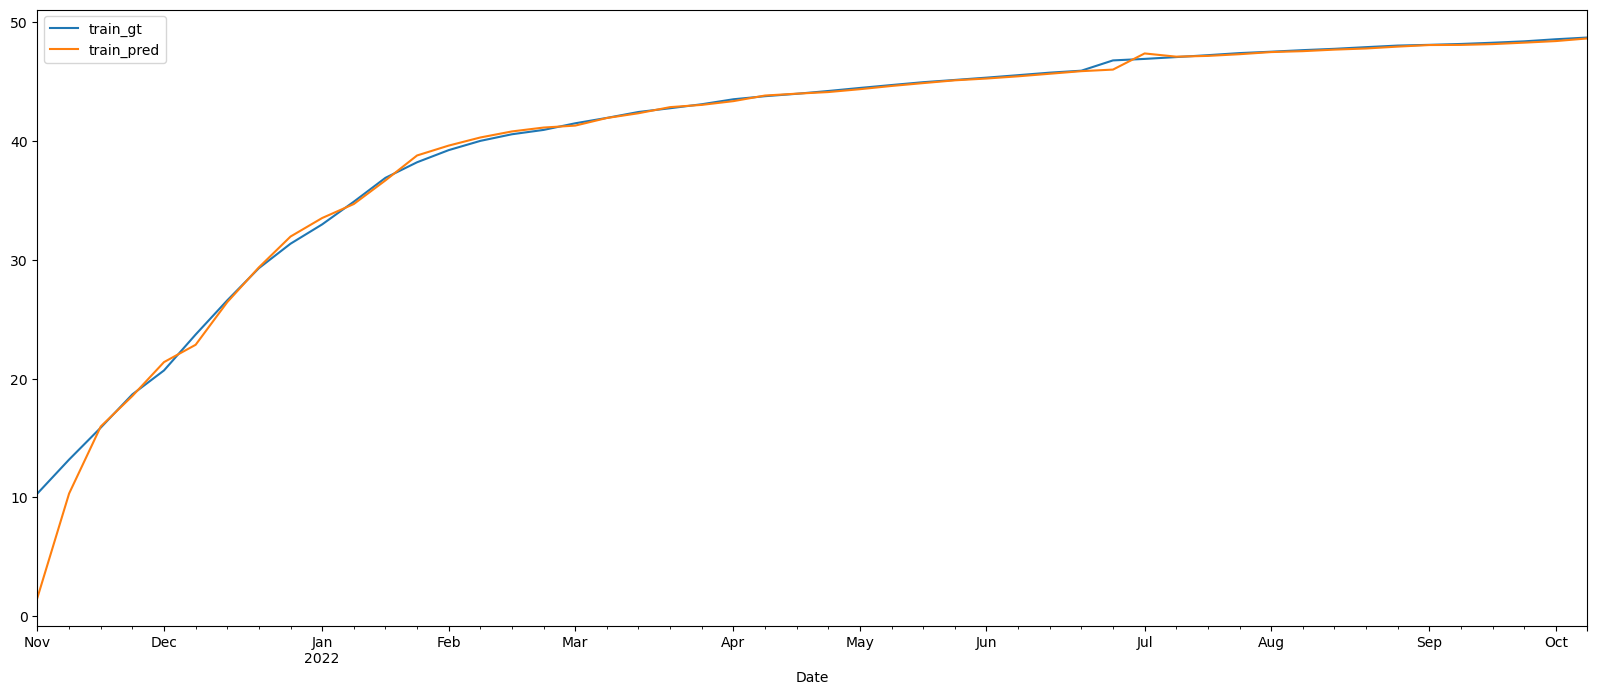

In [33]:
# Results
train_pred=fitted_model.fittedvalues
pd.concat([train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])

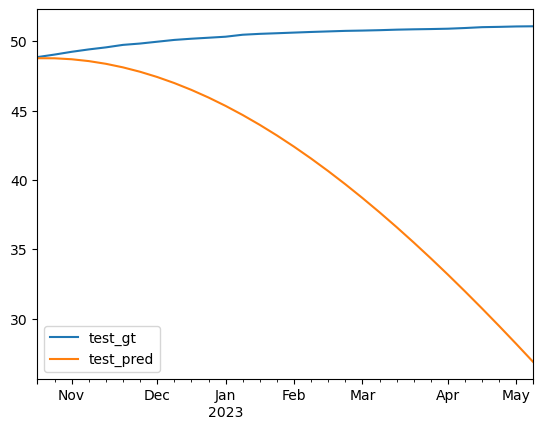

In [34]:
# Visualize the accuracy of these predictions compared to the actual test data

test_pred=fitted_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)
pd.concat([test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

In [42]:
# Fit the SARIMAX model with the best parameters found
model = SARIMAX(train, order=(2, 0, 1), seasonal_order=(0, 0, 0, 0), trend='c')
fitted_model = model.fit(disp=False)

# Validate the model on the test set
start = len(train)
end = start + len(test) - 1
predictions = fitted_model.predict(start=start, end=end, dynamic=False)

# Calculate RMSE for the test set
test_rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: {:.2f}'.format(test_rmse))

Test RMSE: 11.07


# Model 2

In [30]:
# Objective function to be minimized
def arima_objective_function(args_list):
    results = []
    
    for params in args_list:
        try:
            p, d, q = params['p'], params['d'], params['q']
            trend = params['trend']
            
            # Fit ARIMA model
            model = ARIMA(train, order=(p, d, q), trend=trend)
            fitted_model = model.fit()
            
            # Predict and compute RMSE
            predictions = fitted_model.predict(start=train.index[0], end=train.index[-1])
            rmse = sqrt(mean_squared_error(train, predictions))
            
            results.append(rmse)
        except Exception as e:
            # If the model fails to fit, return a large error
            results.append(1e5)
        
    return results

# Define the hyperparameter space
param_space = {
    'p': range(0, 3),  # AR terms
    'd': range(0, 2),  # Differencing
    'q': range(0, 3),  # MA terms
    'trend': ['n', 'c']  # 't' and 'ct' might not be necessary with stationary data
}

# Configuration for Mango tuner
conf_Dict = {
    'num_iteration': 50,
    'initial_random': 10
}

# Instantiate tuner and run the optimization
tuner = Tuner(param_space, arima_objective_function, conf_Dict)
results = tuner.minimize()

# Print the best parameters and the corresponding RMSE
print('Best parameters:', results['best_params'])
print('Best RMSE:', results['best_objective'])


  0%|          | 0/50 [00:00<?, ?it/s]

Best parameters: {'d': 0, 'p': 2, 'q': 2, 'trend': 'c'}
Best RMSE: 0.6077126842324263


In [35]:
# Initialize the ARIMA model
model = ARIMA(train, order=(2, 0, 2))

# Fit the ARIMA model
fitted_model = model.fit()

# Print out the summary of the fit model
print(fitted_model.summary())

                                  SARIMAX Results                                   
Dep. Variable:     Additional_Doses_Vax_Pct   No. Observations:                   50
Model:                       ARIMA(2, 0, 2)   Log Likelihood                 -14.658
Date:                      Mon, 13 Nov 2023   AIC                             41.317
Time:                              00:30:21   BIC                             52.789
Sample:                          11-03-2021   HQIC                            45.685
                               - 10-12-2022                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7720     46.010      0.169      0.866     -82.406      97.950
ar.L1          1.9901      0.008    236.102      0.000       1.974       2.007
ar.L

In [36]:
# Calculate the RMSE
rmse = sqrt(mean_squared_error(train, fitted_model.fittedvalues))
print('The Root Mean Squared Error of the forecasts is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of the forecasts is 0.61


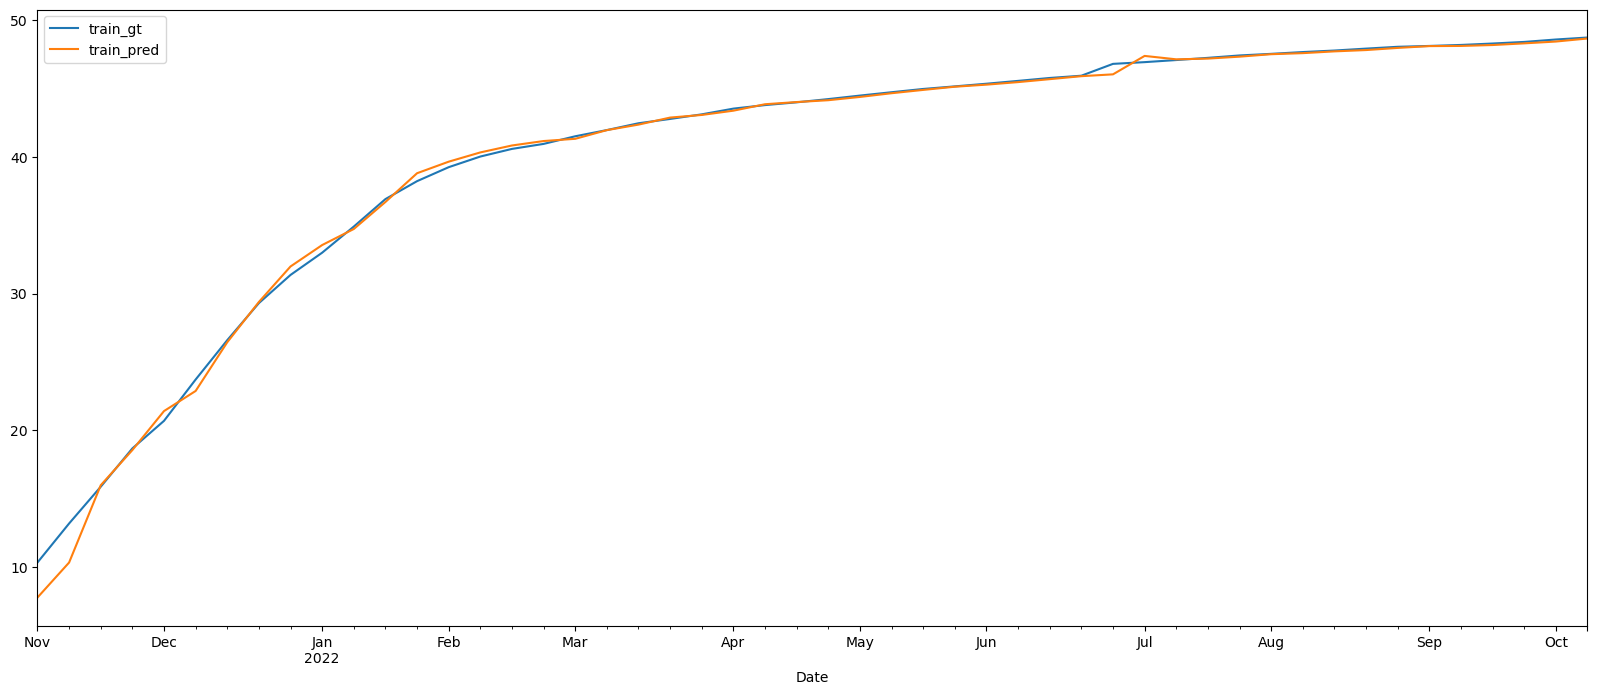

In [37]:
# Results
train_pred=fitted_model.fittedvalues
pd.concat([train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])

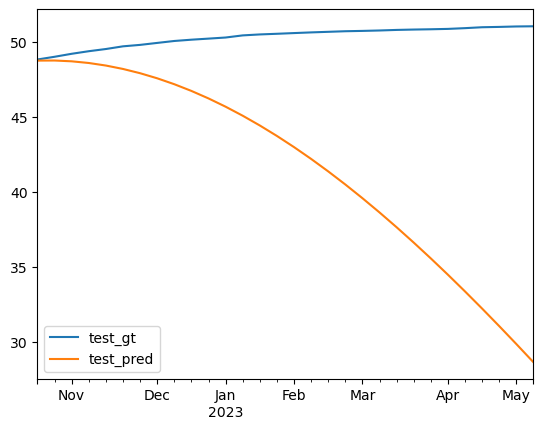

In [38]:
# Visualize the accuracy of these predictions compared to the actual test data

test_pred=fitted_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)
pd.concat([test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

In [43]:
# Fit the SARIMAX model with the best parameters found
model = SARIMAX(train, order=(2, 0, 2), seasonal_order=(0, 0, 0, 0), trend='c')
fitted_model = model.fit(disp=False)

# Validate the model on the test set
start = len(train)
end = start + len(test) - 1
predictions = fitted_model.predict(start=start, end=end, dynamic=False)

# Calculate RMSE for the test set
test_rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: {:.2f}'.format(test_rmse))

Test RMSE: 10.78


# Model 3

In [48]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from mango import Tuner

def arima_objective_function(args_list, train, test):
    results = []
    for params in args_list:
        try:
            p, d, q = params['p'], params['d'], params['q']
            trend = params['trend']
            
            # Fit the ARIMA model
            model = ARIMA(train, order=(p, d, q), trend=trend)
            fitted_model = model.fit()
            
            # Predict on training and test set
            train_pred = fitted_model.predict(start=train.index[0], end=train.index[-1])
            test_pred = fitted_model.predict(start=test.index[0], end=test.index[-1])
            
            # Calculate RMSE for training and test sets
            train_rmse = mean_squared_error(train, train_pred, squared=False)
            test_rmse = mean_squared_error(test, test_pred, squared=False)
            
            # Combine RMSEs with a preference for the test RMSE
            total_rmse = train_rmse * 0.4 + test_rmse * 0.6
            results.append((params, total_rmse))
        except Exception as e:
            # You can decide to print the error or pass
            # print(f"Exception raised for {params}: {e}")
            results.append((params, float('inf')))
    
    return results

param_space = dict(
    p=range(0, 5),  # Search space for p
    d=range(0, 3),  # Search space for d
    q=range(0, 5),  # Search space for q
    trend=['n', 'c', 't', 'ct']
)

conf_dict = {
    'num_iteration': 200,
}

# Assuming 'train' and 'test' DataFrames are already defined
tuner = Tuner(param_space, lambda p: arima_objective_function(p, train=train, test=test), conf_dict)
results = tuner.minimize()
best_params = results['best_params']
best_rmse = results['best_objective']

print(f'Best parameters: {best_params}')
print(f'Best total RMSE (with more weight on test RMSE): {best_rmse}')


TypeError: unsupported operand type(s) for *: 'int' and 'dict'

In [54]:
import optuna
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

def arima_objective(trial, train, test):
    # Define the hyperparameter space
    p = trial.suggest_int('p', 0, 10)
    d = trial.suggest_int('d', 0, 10)
    q = trial.suggest_int('q', 0, 10)
    trend_choices = ['n', 'c', 't', 'ct']
    trend = trial.suggest_categorical('trend', trend_choices)

    # Fit the ARIMA model
    try:
        model = ARIMA(train, order=(p, d, q), trend=trend)
        fitted_model = model.fit()

        # Predict on training and test set
        train_pred = fitted_model.predict(start=train.index[0], end=train.index[-1])
        test_pred = fitted_model.predict(start=test.index[0], end=test.index[-1])
        
        # Calculate RMSE for training and test sets
        train_rmse = mean_squared_error(train, train_pred, squared=False)
        test_rmse = mean_squared_error(test, test_pred, squared=False)
        
        # Optuna tries to minimize the objective, so if you want to give more weight to test RMSE, you can
        # for example, return the weighted average of train and test RMSE
        return train_rmse * 0.4 + test_rmse * 0.6

    except Exception as e:
        # Return a large value to denote failure in optimization
        return np.inf

# Assuming 'train' and 'test' are your training and testing datasets
study = optuna.create_study()
study.optimize(lambda trial: arima_objective(trial, train, test), n_trials=100)

# Retrieve the best parameters
best_params = study.best_params
best_rmse = study.best_value

print(f'Best parameters: {best_params}')
print(f'Best combined RMSE (with more weight on test RMSE): {best_rmse}')


[I 2023-11-13 01:14:35,483] A new study created in memory with name: no-name-74b64b12-27ca-44e8-a677-b45cee201967
[I 2023-11-13 01:14:36,366] Trial 0 finished with value: 5.851243576264473 and parameters: {'p': 8, 'd': 3, 'q': 8, 'trend': 'n'}. Best is trial 0 with value: 5.851243576264473.
[I 2023-11-13 01:14:36,956] Trial 1 finished with value: 113.60698634103095 and parameters: {'p': 0, 'd': 7, 'q': 9, 'trend': 'n'}. Best is trial 0 with value: 5.851243576264473.
[I 2023-11-13 01:14:37,321] Trial 2 finished with value: 8.21747060402745 and parameters: {'p': 0, 'd': 0, 'q': 4, 'trend': 'c'}. Best is trial 0 with value: 5.851243576264473.
[I 2023-11-13 01:14:37,326] Trial 3 finished with value: inf and parameters: {'p': 0, 'd': 7, 'q': 3, 'trend': 'c'}. Best is trial 0 with value: 5.851243576264473.
[I 2023-11-13 01:14:37,334] Trial 4 finished with value: inf and parameters: {'p': 1, 'd': 6, 'q': 3, 'trend': 'ct'}. Best is trial 0 with value: 5.851243576264473.
[I 2023-11-13 01:14:38,

[I 2023-11-13 01:15:00,160] Trial 46 finished with value: 44.53223096550484 and parameters: {'p': 6, 'd': 7, 'q': 4, 'trend': 'n'}. Best is trial 19 with value: 0.8376419295567243.
[I 2023-11-13 01:15:01,255] Trial 47 finished with value: 641.9707929533125 and parameters: {'p': 4, 'd': 10, 'q': 6, 'trend': 'n'}. Best is trial 19 with value: 0.8376419295567243.
[I 2023-11-13 01:15:01,571] Trial 48 finished with value: 1.0974736974381072 and parameters: {'p': 2, 'd': 3, 'q': 3, 'trend': 'n'}. Best is trial 19 with value: 0.8376419295567243.
[I 2023-11-13 01:15:02,181] Trial 49 finished with value: 3.269668048448375 and parameters: {'p': 3, 'd': 0, 'q': 5, 'trend': 'c'}. Best is trial 19 with value: 0.8376419295567243.
[I 2023-11-13 01:15:03,085] Trial 50 finished with value: 1.1857114149608436 and parameters: {'p': 7, 'd': 2, 'q': 7, 'trend': 'n'}. Best is trial 19 with value: 0.8376419295567243.
[I 2023-11-13 01:15:03,663] Trial 51 finished with value: 0.8666056926763808 and parameters:

[I 2023-11-13 01:15:23,425] Trial 92 finished with value: 0.8245864060080161 and parameters: {'p': 7, 'd': 1, 'q': 6, 'trend': 'n'}. Best is trial 53 with value: 0.8066799557603757.
[I 2023-11-13 01:15:23,868] Trial 93 finished with value: 7.965583323293637 and parameters: {'p': 6, 'd': 0, 'q': 6, 'trend': 'n'}. Best is trial 53 with value: 0.8066799557603757.
[I 2023-11-13 01:15:24,363] Trial 94 finished with value: 1.199538176864725 and parameters: {'p': 4, 'd': 2, 'q': 7, 'trend': 'n'}. Best is trial 53 with value: 0.8066799557603757.
[I 2023-11-13 01:15:24,395] Trial 95 finished with value: inf and parameters: {'p': 7, 'd': 1, 'q': 6, 'trend': 'c'}. Best is trial 53 with value: 0.8066799557603757.
[I 2023-11-13 01:15:25,027] Trial 96 finished with value: 1.321848837766705 and parameters: {'p': 6, 'd': 1, 'q': 8, 'trend': 'n'}. Best is trial 53 with value: 0.8066799557603757.
[I 2023-11-13 01:15:25,513] Trial 97 finished with value: 0.8666056926763808 and parameters: {'p': 5, 'd': 2

Best parameters: {'p': 4, 'd': 1, 'q': 6, 'trend': 'n'}
Best combined RMSE (with more weight on test RMSE): 0.8066799557603757


In [56]:
# Initialize the ARIMA model
model = ARIMA(train, order=(4, 1, 6))

# Fit the ARIMA model
fitted_model = model.fit()

# Print out the summary of the fit model
print(fitted_model.summary())

# Calculate the RMSE
rmse = sqrt(mean_squared_error(train, fitted_model.fittedvalues))
print('The Root Mean Squared Error of the forecasts is {}'.format(round(rmse, 2)))

# Fit the SARIMAX model with the best parameters found
model = SARIMAX(train, order=(4, 1, 6), seasonal_order=(0, 0, 0, 0), trend='c')
fitted_model = model.fit(disp=False)

# Validate the model on the test set
start = len(train)
end = start + len(test) - 1
predictions = fitted_model.predict(start=start, end=end, dynamic=False)

# Calculate RMSE for the test set
test_rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: {:.2f}'.format(test_rmse))

                                  SARIMAX Results                                   
Dep. Variable:     Additional_Doses_Vax_Pct   No. Observations:                   50
Model:                       ARIMA(4, 1, 6)   Log Likelihood                  -3.375
Date:                      Mon, 13 Nov 2023   AIC                             28.749
Time:                              01:25:55   BIC                             49.559
Sample:                          11-03-2021   HQIC                            36.644
                               - 10-12-2022                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1439      0.284      0.506      0.613      -0.413       0.701
ar.L2          0.2931      0.415      0.705      0.481      -0.521       1.107
ar.L

In [57]:
# Function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

# Define the p, d, q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# Define the search space for seasonal p, d, q and s 
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Record the best score and ARIMA order
best_rmse = float('inf')
best_order = None
best_sorder = None


for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            # Fit the SARIMAX model
            mod = SARIMAX(train,
                          order=param,
                          seasonal_order=seasonal_param,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            results = mod.fit(disp=False)
            
            # Get predictions starting from the end of the training set
            start = len(train)
            end = start + len(test) - 1
            predictions = results.predict(start=start, end=end, dynamic=False)
            
            # Calculate RMSE
            rmse = calculate_rmse(test, predictions)
            
            # Compare with the best RMSE
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = param
                best_sorder = seasonal_param
                
        except:
            continue

print('Best ARIMA{}x{}12 model - AIC:{}'.format(best_order, best_sorder, best_rmse))

Best ARIMA(1, 1, 0)x(0, 0, 2, 12)12 model - AIC:0.1639110525497846


In [59]:
# Initialize the ARIMA model
model = ARIMA(train, order=(1, 1, 0))

# Fit the ARIMA model
fitted_model = model.fit()

# Print out the summary of the fit model
print(fitted_model.summary())

# Calculate the RMSE
rmse = sqrt(mean_squared_error(train, fitted_model.fittedvalues))
print('The Root Mean Squared Error of the forecasts is {}'.format(round(rmse, 2)))

# Fit the SARIMAX model with the best parameters found
model = SARIMAX(train, order=(1, 1, 0), seasonal_order=(0, 0, 2, 12), trend='c')
fitted_model = model.fit(disp=False)

# Validate the model on the test set
start = len(train)
end = start + len(test) - 1
predictions = fitted_model.predict(start=start, end=end, dynamic=False)

# Calculate RMSE for the test set
test_rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: {:.2f}'.format(test_rmse))

                                  SARIMAX Results                                   
Dep. Variable:     Additional_Doses_Vax_Pct   No. Observations:                   50
Model:                       ARIMA(1, 1, 0)   Log Likelihood                 -12.206
Date:                      Mon, 13 Nov 2023   AIC                             28.411
Time:                              09:57:54   BIC                             32.195
Sample:                          11-03-2021   HQIC                            29.847
                               - 10-12-2022                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9847      0.014     70.433      0.000       0.957       1.012
sigma2         0.0897      0.011      7.947      0.000       0.068       0.112
Ljun

In [16]:
# Initialize the ARIMA model
model = ARIMA(train, order=(10, 0, 3))

# Fit the ARIMA model
fitted_model = model.fit()

# Print out the summary of the fit model
print(fitted_model.summary())

# Calculate the RMSE
rmse = sqrt(mean_squared_error(train, fitted_model.fittedvalues))
print('The Root Mean Squared Error of the forecasts is {}'.format(round(rmse, 2)))

# Fit the SARIMAX model with the best parameters found
model = SARIMAX(train, order=(10, 0, 3), seasonal_order=(0, 0, 0,0), trend='c')
fitted_model = model.fit(disp=False)

# Validate the model on the test set
start = len(train)
end = start + len(test) - 1
predictions = fitted_model.predict(start=start, end=end, dynamic=False)

# Calculate RMSE for the test set
test_rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: {:.2f}'.format(test_rmse))

                                  SARIMAX Results                                   
Dep. Variable:     Additional_Doses_Vax_Pct   No. Observations:                   56
Model:                      ARIMA(10, 0, 3)   Log Likelihood                  -7.067
Date:                      Mon, 13 Nov 2023   AIC                             44.135
Time:                              12:44:33   BIC                             74.515
Sample:                          11-03-2021   HQIC                            55.913
                               - 11-23-2022                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.9433     21.050      1.945      0.052      -0.313      82.200
ar.L1         -0.4908      0.495     -0.992      0.321      -1.461       0.479
ar.L